In [1]:
%matplotlib inline

In [2]:
# Third party imports
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from obspy.io.quakeml.core import Unpickler
import pandas as pd

# Local imports
from libcomcat.dataframes import get_phase_dataframe, get_magnitude_data_frame
from libcomcat.search import get_event_by_id

# Detailed Dataframes Overview
----

The get_phase_dataframe() method allows the user to retrieve a table of "picks" - that is the arrivals of various seismic waves (P, S, and so on) at different stations. These same tables can be viewed on the event pages:

https://earthquake.usgs.gov/earthquakes/eventpage/nc73201181/origin/phase

The get_magnitude_dataframe() method allows the user to retrieve a table of station amplitudes and magnitudes. These tables can also be viewed on the event pages:

https://earthquake.usgs.gov/earthquakes/eventpage/nc73201181/origin/magnitude

## Contents
----

- [get_phase_dataframe](#get_phase_dataframe)
- [get_magnitude_dataframe](#get_magnitude_dataframe)


## get_phase_dataframe
To use the get_phase_dataframe() method, first retrieve a DetailEvent object (see the Classes notebook) and set the includesuperseded property to True. This object is passed as the positional argument to get_phase_dataframe, along with the desired catalog (us, ci, etc.)

In [3]:
eventid = 'nc73201181'
regional = 'nc'
detail = get_event_by_id(eventid, includesuperseded=True)

Inspect the ComCat event page [Origins](https://earthquake.usgs.gov/earthquakes/eventpage/nc73201181/origin/phase) tab to see which catalogs have provided origins for the event. Here there is a US (National Earthquake Information Center) solution and one from Northern California (NC).

Note that some data cleaning is done after retrieving the dataframe - removing automatic picks and making sure that both dataframes represent missing locations with an empty string instead of "--".

In [4]:
usframe = get_phase_dataframe(detail, catalog='us')
usframe = usframe[usframe['Status'] == 'manual']
usframe['Channel'] = usframe['Channel'].str.replace('--','')
# note that the line below merely prints the sorted dataframe, 
# it does not modify the dataframe to be sorted by Channel.
usframe.sort_values('Channel')

,Channel,Distance,Azimuth,Phase,Arrival Time,Status,Residual,Weight,Agency
145,AK.CHN.BHZ.,27.56120,313.7820,P,2019-06-23 03:58:50.960,manual,1.6,0.82,us
118,AK.UNV.BHZ.,31.29330,310.0130,P,2019-06-23 03:59:25.280,manual,2.8,0.85,us
146,AT.AKUT.BHZ.,30.91080,310.6970,P,2019-06-23 03:59:21.530,manual,2.4,0.84,us
163,AT.SKAG.BHZ.,20.42710,343.7550,P,2019-06-23 03:57:42.440,manual,2.7,0.65,us
195,BC.CBX.HHZ.,10.04970,139.8350,Pn,2019-06-23 03:55:26.530,manual,-0.6,0.89,us
...,...,...,...,...,...,...,...,...,...
26,UW.SOUA.ENZ.,2.25946,31.8477,Pn,2019-06-23 03:53:40.090,manual,-0.2,0.00,nc
200,WR.HUF.EHZ.,2.62728,93.8979,Pn,2019-06-23 03:53:45.480,manual,-0.1,0.00,us
199,WR.KPK.EHZ.,2.40380,105.6940,Pn,2019-06-23 03:53:40.540,manual,-1.8,0.00,us
23,WR.PAM.EHZ.,2.29301,110.1500,Pn,2019-06-23 03:53:38.230,manual,-2.5,0.00,nc


In [5]:
regframe = get_phase_dataframe(detail, catalog=regional)
regframe = regframe[regframe['Status'] == 'manual']
regframe['Channel'] = regframe['Channel'].str.replace('--','')
regframe.sort_values('Channel')

,Channel,Distance,Azimuth,Phase,Arrival Time,Status,Residual,Weight,Agency
94,BG.AL1.DPZ.,1.804,142.3,P,2019-06-23 03:53:31.880,manual,-0.58,0.00,NC
98,BG.AL2.DPZ.,1.815,143.0,P,2019-06-23 03:53:31.980,manual,-0.63,0.00,NC
101,BG.AL3.DPZ.,1.825,142.0,P,2019-06-23 03:53:32.160,manual,-0.59,0.00,NC
102,BG.AL4.DPZ.,1.826,141.3,P,2019-06-23 03:53:32.340,manual,-0.43,0.00,NC
96,BG.AL5.DPZ.,1.81,141.9,P,2019-06-23 03:53:31.890,manual,-0.64,0.00,NC
...,...,...,...,...,...,...,...,...,...
39,PB.B935.EHZ.,0.5921,69.4,P,2019-06-23 03:53:15.620,manual,0.25,0.16,NC
156,UW.SOUA.ENZ.,2.26,31.8,P,2019-06-23 03:53:40.090,manual,1.22,0.00,NC
189,WR.HUF.EHZ.,2.627,93.9,P,2019-06-23 03:53:45.480,manual,1.43,0.00,NC
174,WR.KPK.EHZ.,2.404,105.8,P,2019-06-23 03:53:40.540,manual,-1.81,0.00,NC


Next the common station/channel/phase rows can be found in each dataframe, and create a new one with the arrival times and arrival time residuals from each catalog. *Note: There is probably a way to accomplish the below task without looping, but this approach is perhaps more clear to the new pandas user.*

In [6]:
columns=['Channel','Phase','Distance','US Time','NC Time','US Residual', 'NC Residual']
newframe = pd.DataFrame(columns=columns)
for idx, usrow in usframe.iterrows():
    us_channel = '.'.join(usrow['Channel'].split('.')[0:3])
    c1 = regframe['Channel'] == usrow['Channel']
    if usrow['Phase'] in ['Pn','Pg']:
        usphase = 'P'
    else:
        usphase = usrow['Phase']
    c2 = regframe['Phase'] == usphase
    regrow = regframe[c1 & c2]
    if not len(regrow):
        continue
    regrow = regrow.iloc[0]
    newrow = {}
    newrow['Channel'] = usrow['Channel']
    newrow['Phase'] = usrow['Phase']
    newrow['Distance'] = usrow['Distance']
    newrow['US Time'] = usrow['Arrival Time']
    newrow['NC Time'] = regrow['Arrival Time']
    newrow['US Residual'] = usrow['Residual']
    newrow['NC Residual'] = regrow['Residual']
    newframe = newframe.append(newrow, ignore_index=True)
newframe['dt'] = (newframe['NC Time'] - newframe['US Time']).dt.total_seconds()
newframe

,Channel,Phase,Distance,US Time,NC Time,US Residual,NC Residual,dt
0,NC.KMR.HHZ.,Pg,0.45851,2019-06-23 03:53:12.930,2019-06-23 03:53:12.910,1.1,-0.11,-0.02
1,BK.ORV.BHZ.00,Pn,2.26993,2019-06-23 03:53:38.060,2019-06-23 03:53:38.060,-2.4,-0.84,0.00
2,CE.68586.HNZ.10,Pn,2.63557,2019-06-23 03:53:43.630,2019-06-23 03:53:43.630,-1.8,-0.53,0.00
3,NC.NTO.EHZ.,Pn,2.56719,2019-06-23 03:53:42.170,2019-06-23 03:53:42.170,-2.3,-1.03,0.00
4,NP.1762.HNZ.10,Pn,2.55711,2019-06-23 03:53:42.820,2019-06-23 03:53:42.820,-1.5,-0.24,0.00
...,...,...,...,...,...,...,...,...
133,NC.LPG.EHZ.,Pn,1.24144,2019-06-23 03:53:25.220,2019-06-23 03:53:25.220,-1.1,0.34,0.00
134,NC.LRB.EHZ.,Pn,1.34085,2019-06-23 03:53:26.870,2019-06-23 03:53:26.870,-0.8,0.23,0.00
135,NC.LRD.EHZ.,Pn,2.17580,2019-06-23 03:53:38.240,2019-06-23 03:53:38.240,-1.1,-0.14,0.00
136,NC.LRR.EHZ.,Pn,2.05501,2019-06-23 03:53:36.270,2019-06-23 03:53:36.270,-1.4,-0.16,0.00


Let's plot now the station distance vs arrival time difference (Regional-NEIC).

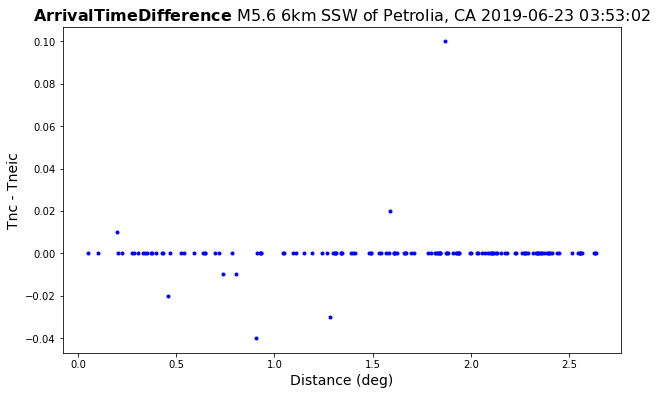

In [7]:
fig = plt.figure(figsize=(10,6));
ax = plt.gca();
plt.plot(newframe['Distance'],newframe['dt'],'b.');
tfmt = r'$\bf{Arrival Time Difference}$ M%.1f %s %s'
timestr = detail.time.strftime('%Y-%m-%d %H:%M:%S')
plt.title(tfmt % (detail.magnitude, detail.location, timestr), fontsize=16);
plt.xlabel('Distance (deg)', fontsize=14);
plt.ylabel('T%s - Tneic' % regional, fontsize=14);

## get_magnitude_dataframe

To use the get_magnitude_dataframe() method, get a DetailEvent object (re-use the one from above) and pass this object plus the catalog and magnitude type (ml, mb, etc.) as positional arguments to get_phase_dataframe.

Again do some data cleaning to remove "--" locations.

In [8]:
usmagframe = get_magnitude_data_frame(detail, 'us', 'ml')
usmagframe['Channel'] = usmagframe['Channel'].str.replace('--','')
usmagframe.sort_values('Channel')

,Channel,Type,Amplitude,Period,Status,Magnitude,Weight
10,BK.BUCR.BHE.00,ML,0.000004,2.825,automatic,5.29,1.0
11,BK.BUCR.BHN.00,ML,0.000003,2.750,automatic,5.19,0.0
16,BK.CMB.BHE.00,ML,0.000003,2.600,automatic,5.10,0.0
17,BK.CMB.BHN.00,ML,0.000003,2.025,automatic,5.10,0.0
20,BK.CVS.BHE.00,ML,0.000016,2.175,automatic,5.30,1.0
...,...,...,...,...,...,...,...
111,US.WVOR.BH2.00,ML,0.000002,4.250,automatic,5.25,0.0
2,UW.BBO.HHE.,ML,0.000011,1.510,automatic,5.33,1.0
3,UW.BBO.HHN.,ML,0.000008,2.390,automatic,5.19,0.0
42,UW.JEDS.HHE.,ML,0.000012,4.680,automatic,5.58,1.0


In [9]:
regmagframe = get_magnitude_data_frame(detail, regional, 'ml')
regmagframe['Channel'] = regmagframe['Channel'].str.replace('--','')
regmagframe.sort_values('Channel')

,Channel,Type,Amplitude,Period,Status,Magnitude,Weight
284,BK.BDM.HHE.00,ML,0.026908,None,manual,5.46,1.0
496,BK.BDM.HHN.00,ML,0.008534,None,manual,4.97,1.0
79,BK.BKS.HHE.00,ML,0.011861,None,manual,5.21,1.0
289,BK.BKS.HHN.00,ML,0.008741,None,manual,5.07,1.0
525,BK.BL67.HHE.00,ML,0.011907,None,manual,5.26,1.0
...,...,...,...,...,...,...,...
146,WR.SPR.HNE.,ML,0.005367,None,manual,5.10,0.0
186,WR.THER.HNE.00,ML,0.111080,None,manual,5.92,0.0
646,WR.THER.HNE.03,ML,0.021893,None,manual,5.21,0.0
235,WR.THER.HNN.00,ML,0.065901,None,manual,5.69,0.0


Create a new dataframe with NEIC and Regional magnitudes for the same stations.

In [10]:
columns=['Channel','Type','US Magnitude','Regional Magnitude']
newmagframe = pd.DataFrame(columns=columns)
for idx, usrow in usmagframe.iterrows():
    us_channel = '.'.join(usrow['Channel'].split('.')[0:3])
    c1 = regmagframe['Channel'] == usrow['Channel']
    ncrow = regmagframe[c1]
    if not len(ncrow):
        continue
    ncrow = ncrow.iloc[0]
    newrow = {}
    newrow['Channel'] = usrow['Channel']
    newrow['Type'] = usrow['Type']
    newrow['US Magnitude'] = usrow['Magnitude']
    newrow['Regional Magnitude'] = ncrow['Magnitude']
    newmagframe = newmagframe.append(newrow, ignore_index=True)
newmagframe

,Channel,Type,US Magnitude,Regional Magnitude
0,NC.AFD.HHE.,ML,5.04,5.29
1,NC.AFD.HHN.,ML,5.08,5.25
2,NN.BEK.HHE.,ML,5.25,5.43
3,NN.BEK.HHN.,ML,5.56,5.86
4,NC.GDXB.HHE.,ML,4.97,5.30
5,NC.GDXB.HHN.,ML,5.01,5.45
6,NC.KBO.HHE.,ML,5.42,5.44
7,NC.KBO.HHN.,ML,5.48,5.37
8,NC.KEB.HHE.,ML,5.45,5.60
9,NC.KEB.HHN.,ML,5.39,5.54


Plot NEIC magnitudes vs Regional magnitudes for the same stations. Here the NC magnitudes are generally larger for the same stations by about 19% (mean ratio between regional/us moments).

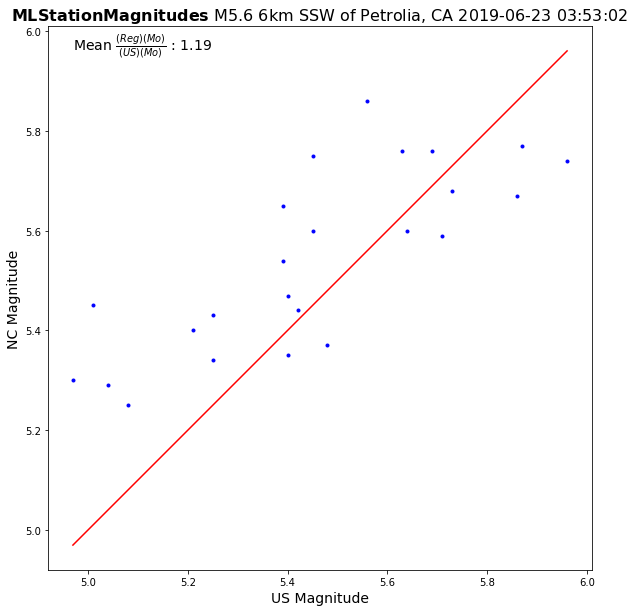

In [11]:
usmag = newmagframe['US Magnitude']
regmag = newmagframe['Regional Magnitude']
fig = plt.figure(figsize=(10,10));
plt.plot(usmag, regmag,'b.');
minmag = min(usmag.min(),regmag.min())
maxmag = max(usmag.max(),regmag.max())

# figure out the mean ratio of regional magnitude to NEIC magnitude
reg_m0 = np.exp((regmag * 1.5) + 9.0)
us_m0 = np.exp((usmag * 1.5) + 9.0)
mean_mag_ratio = np.mean(reg_m0/us_m0);
plt.text(minmag, maxmag,r'Mean $\frac{(Reg) (Mo)}{(US) (Mo)}$ : %.2f' % mean_mag_ratio, fontsize=14)

dm = maxmag - minmag
plt.axis([minmag, maxmag, minmag, maxmag]);
plt.plot([minmag, maxmag], [minmag, maxmag],'r');
plt.xlabel('US Magnitude', fontsize=14);
plt.ylabel('%s Magnitude' % regional.upper(), fontsize=14);
tfmt = r'$\bf{ML Station Magnitudes}$ M%.1f %s %s'
plt.title(tfmt % (detail.magnitude, detail.location, timestr), fontsize=16);
# plt.title('ML Station Magnitudes US vs. %s' % regional.upper());
plt.axis('square');